# Project 5B: Flow Matching from Scratch!

## Setup environment

In [7]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

In [8]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm
import torch
import torch.nn as nn

## Neural Network Resources

In this part, you will build and train a [UNet](https://arxiv.org/abs/1505.04597), which is more complex than the MLP you implemented in the NeRF project.  We provide all class definitions you may need (but feel free to add or modify them as necessary).  

Instead of asking ChatGPT to write everything for you, please consult the following resources when you get stuck — they will help you understand how and why things work under the hood.

- PyTorch Documentation — [`Conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [`ConvTranspose2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html), and [`AvgPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html).
- PyTorch Documentation - [`torchvision.datasets.MNIST`](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html), the dataset we gonna use, and [`torch.utils.data.DataLoader`](https://docs.pytorch.org/docs/stable/data.html), the off-the-shell dataloader we can directly use.
- PyTorch [tutorial](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) on how to train a classifier on CIFAR10 dataset. The structure of your training code will be very similar to this one.

# Part 1: Training a Single-step Denoising UNet


# Part 1.1: Implementing the UNet

## Implementing Simple and Composed Ops

In [9]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        #conv2d(3,1,1)+BN+GELU
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.seq(x)
        # ===== end of code ====

class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.seq(x)
        # ===== end of code ====

class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.seq = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.seq(x)
        # ===== end of code ====

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        # ===== your code here! ====
        self.seq = nn.Sequential(
            nn.AvgPool2d(kernel_size=7),
            nn.GELU()
        )
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.seq(x)
        # ===== end of code ====

class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.seq = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
            nn.GELU()
        )
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.seq(x)
        # ===== end of code ====

class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.seq = nn.Sequential(
            Conv(in_channels, out_channels),
            Conv(out_channels, out_channels)
        )
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.seq(x)
        # ===== end of code ====


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.seq = nn.Sequential(
            DownConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.seq(x)
        # ===== end of code ====

class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.seq = nn.Sequential(
            UpConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.seq(x)
        # ===== end of code ====

## Implementing Unconditional UNet

In [10]:
from torch.nn.modules.conv import Conv2d
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        # ===== your code here! ====
        #down
        self.conv1 = ConvBlock(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)

        #bottom
        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)

        #up
        self.up1 = UpBlock(4 * num_hiddens, num_hiddens)
        self.up2 = UpBlock(2 * num_hiddens, num_hiddens)

        #to the right
        self.conv2 = ConvBlock(2* num_hiddens, num_hiddens)
        self.conv3 = nn.Conv2d(in_channels=num_hiddens, out_channels=in_channels, kernel_size=3, stride=1, padding=1)
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # ===== your code here! ====
        x1 = self.conv1(x)

        #down
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        #bottom
        flat = self.flatten(x3)
        unflat = self.unflatten(flat)

        # up need to concat with unflat and down2 (x3)
        x = torch.cat([unflat, x3], dim=1)
        x = self.up1(x)

        # concat with up1 and down1 (x2)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x)

        # concat with initial conv1
        x = torch.cat([x, x1], dim=1)
        x = self.conv2(x)

        return self.conv3(x)
        # ===== end of code ====
        raise NotImplementedError()

# Part 1.2: Using the UNet to Train a Denoiser

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2250284319.py:16: SyntaxWarning: invalid escape sequence '\s'
  axes[i].set_title(f"$\sigma$ = {sigma}")


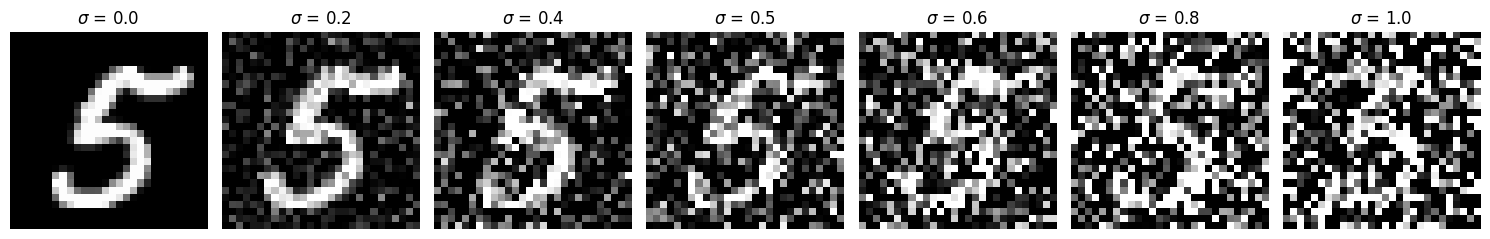

In [12]:
x, _ = next(iter(train_dataloader))
clean_image = x[0]

sigmas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

fig, axes = plt.subplots(1, len(sigmas), figsize=(15, 5))

for i, sigma in enumerate(sigmas):
    epsilon = torch.randn_like(clean_image)

    noisy_image = clean_image + sigma * epsilon

    noisy_image = torch.clamp(noisy_image, 0, 1)

    axes[i].imshow(noisy_image.squeeze().cpu(), cmap='gray')
    axes[i].set_title(f"$\sigma$ = {sigma}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Part 1.2.1: Training

For this part, we provide some structure code for training. It is very basic, so feel free to change them or add your code. In later section we won't provide any training or visualization structure code.

In [13]:
import torch.optim as optim

device = torch.device('cuda')

# Set your hyperparameters
# ===== your code here! ====
batch_size = 256
learning_rate = 1e-4
noise_level = 0.5
hidden_dim = 128
num_epochs = 5
# ===== end of code ====

In [14]:
# Define your datasets and dataloaders
# ===== your code here! ====
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# ===== end of code ====

In [15]:
# Define your model, optimizer, and loss
# ===== your code here! ====
model = UnconditionalUNet(in_channels=1, num_hiddens=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
# ===== end of code ====

100%|██████████| 235/235 [00:17<00:00, 13.52it/s]


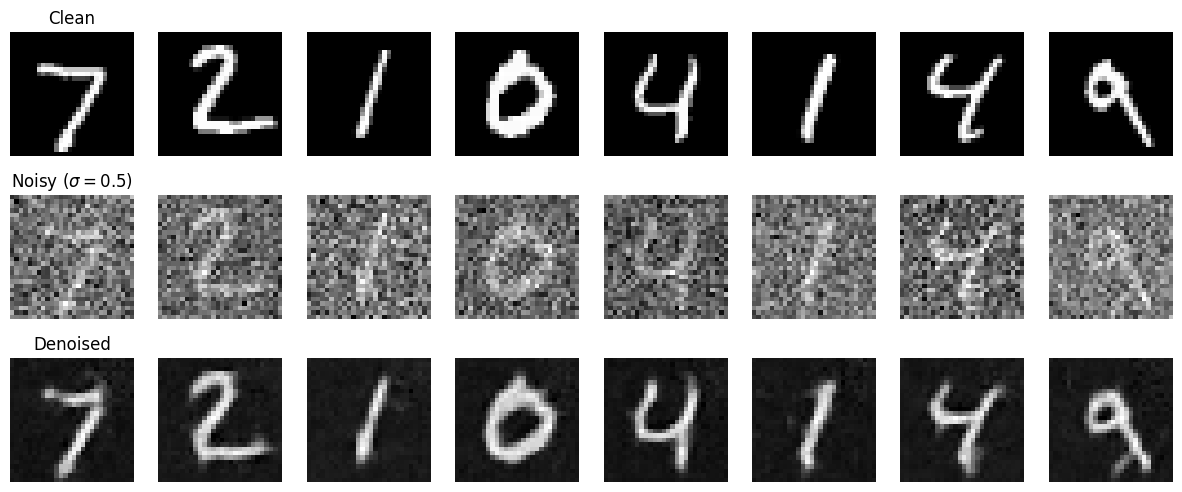

100%|██████████| 235/235 [00:15<00:00, 15.04it/s]


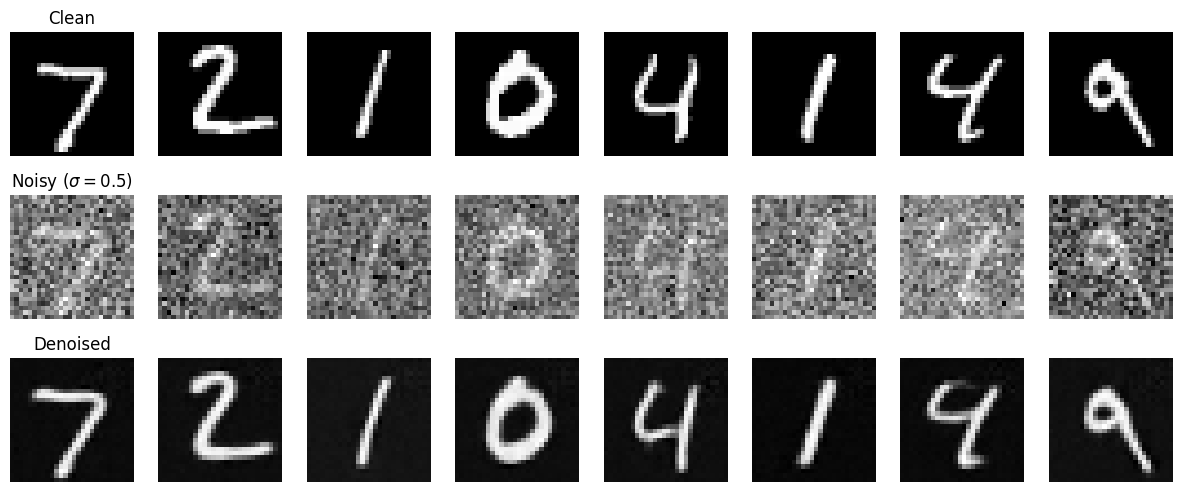

In [16]:
# The training loops
train_losses = []
for epoch in range(num_epochs):
    model.train()

    for i, (images, _) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        noise = torch.randn_like(images)
        noisy_images = images + noise_level * noise
        outputs = model(noisy_images)
        # ===== end of code ====

        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    if (epoch + 1) in [1, 5]:
        model.eval()
        with torch.no_grad():
            test_x, _ = next(iter(test_loader))
            test_x = test_x.to(device)

            test_noise = torch.randn_like(test_x)
            test_noisy = test_x + noise_level * test_noise

            test_denoised = model(test_noisy)

            fig, axes = plt.subplots(3, 8, figsize=(15, 6))
            for k in range(8):
                axes[0, k].imshow(test_x[k].squeeze().cpu(), cmap='gray')
                axes[0, k].axis('off')
                if k == 0: axes[0, k].set_title("Clean")

                axes[1, k].imshow(test_noisy[k].squeeze().cpu(), cmap='gray')
                axes[1, k].axis('off')
                if k == 0: axes[1, k].set_title(rf"Noisy ($\sigma={noise_level}$)")

                axes[2, k].imshow(test_denoised[k].squeeze().cpu(), cmap='gray')
                axes[2, k].axis('off')
                if k == 0: axes[2, k].set_title("Denoised")
            plt.show()

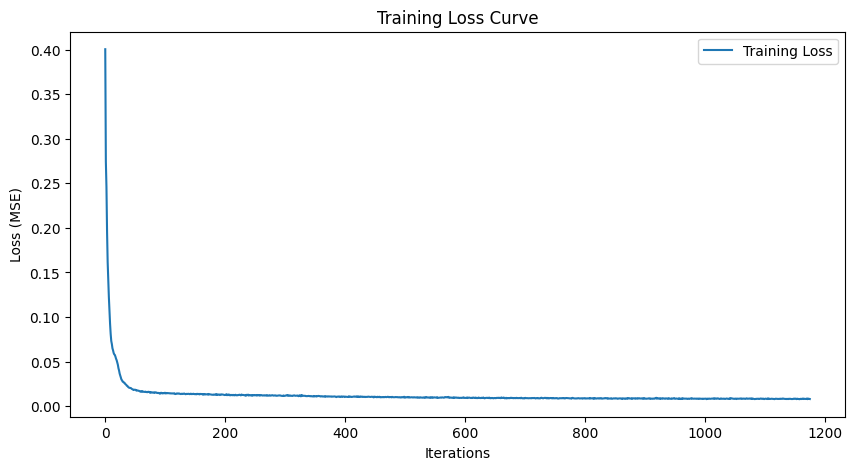

In [17]:
# Visualize your training curve
# ===== your code here! ====
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# ===== end of code ====

## Part 1.2.2: Out-of-Distribution Testing

<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1299382221.py:27: SyntaxWarning: invalid escape sequence '\s'
  axes[i, 1].set_title(f"Input ($\sigma={sigma}$)")


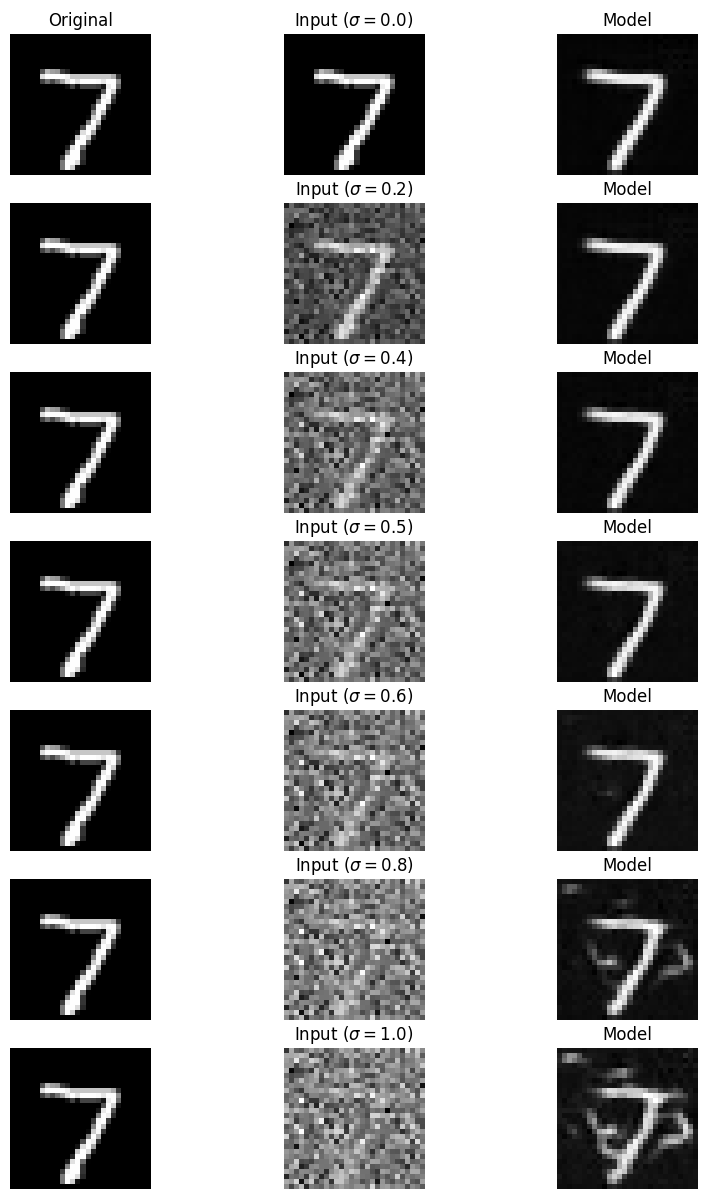

In [18]:
import matplotlib.pyplot as plt
import torch

sigmas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

data_iter = iter(test_loader)
clean_images, _ = next(data_iter)
clean_image = clean_images[0:1].to(device)

model.eval()
epsilon = torch.randn_like(clean_image)

fig, axes = plt.subplots(len(sigmas), 3, figsize=(10, 15))

with torch.no_grad():
    for i, sigma in enumerate(sigmas):
        noisy_image = clean_image + sigma * epsilon

        denoised_image = model(noisy_image)

        axes[i, 0].imshow(clean_image.squeeze().cpu(), cmap='gray')
        axes[i, 0].axis('off')
        if i == 0: axes[i, 0].set_title("Original")

        axes[i, 1].imshow(noisy_image.squeeze().cpu(), cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Input ($\sigma={sigma}$)")

        axes[i, 2].imshow(denoised_image.squeeze().cpu(), cmap='gray')
        axes[i, 2].axis('off')
        axes[i, 2].set_title("Model")

## Part 1.2.3 Denoising Pure Noise

In [19]:
import os
checkpoint_dir = '/content/drive/MyDrive/cs180/proj5checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

Starting training on PURE NOISE...


100%|██████████| 235/235 [00:15<00:00, 15.02it/s]


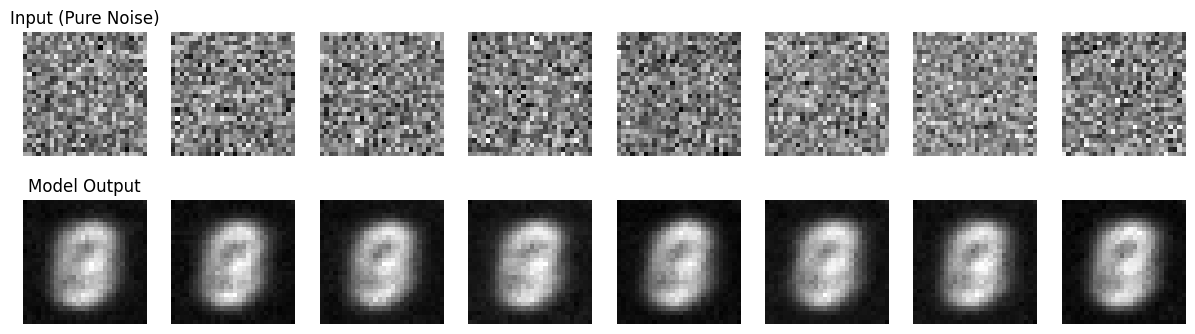

100%|██████████| 235/235 [00:15<00:00, 14.97it/s]


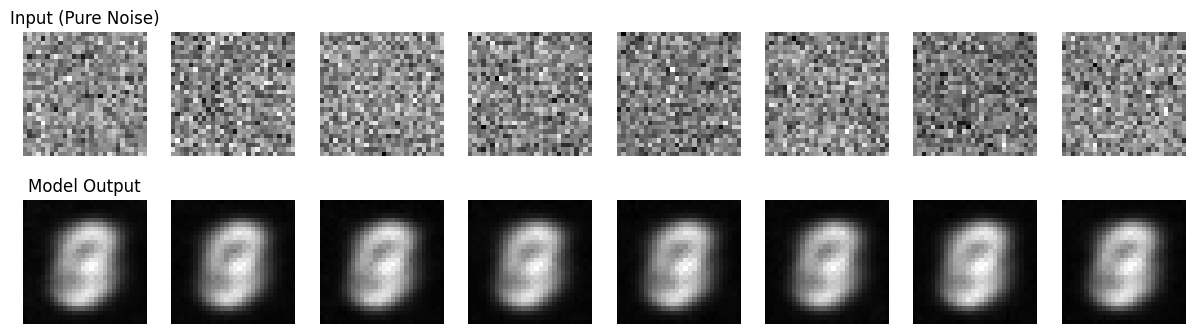

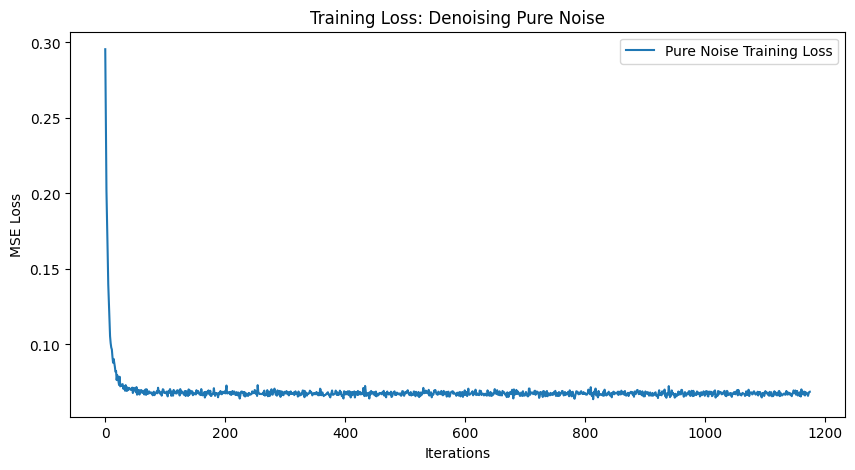

In [20]:
model_pure = UnconditionalUNet(in_channels=1, num_hiddens=128).to(device)
optimizer_pure = optim.Adam(model_pure.parameters(), lr=1e-4)
criterion = nn.MSELoss()

pure_losses = []
num_epochs = 5

print("Starting training on PURE NOISE...")

for epoch in range(num_epochs):
    model_pure.train()

    for i, (images, _) in enumerate(tqdm(train_loader)):
        images = images.to(device)

        noise_input = torch.randn_like(images).to(device)

        outputs = model_pure(noise_input)

        loss = criterion(outputs, images)

        optimizer_pure.zero_grad()
        loss.backward()
        optimizer_pure.step()

        pure_losses.append(loss.item())

    checkpoint_path = os.path.join(checkpoint_dir, f'pure_noise_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_pure.state_dict(),
        'optimizer_state_dict': optimizer_pure.state_dict(),
        'loss': loss,
    }, checkpoint_path)

    if (epoch + 1) in [1, 5]:
        model_pure.eval()
        with torch.no_grad():
            sample_noise = torch.randn(8, 1, 28, 28).to(device)

            generated_images = model_pure(sample_noise)

            fig, axes = plt.subplots(2, 8, figsize=(15, 4))
            for k in range(8):
                axes[0, k].imshow(sample_noise[k].squeeze().cpu(), cmap='gray')
                axes[0, k].axis('off')
                if k == 0: axes[0, k].set_title("Input (Pure Noise)")

                axes[1, k].imshow(generated_images[k].squeeze().cpu(), cmap='gray')
                axes[1, k].axis('off')
                if k == 0: axes[1, k].set_title("Model Output")
            plt.show()

plt.figure(figsize=(10, 5))
plt.plot(pure_losses, label='Pure Noise Training Loss')
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.title('Training Loss: Denoising Pure Noise')
plt.legend()
plt.show()

# Part 2: Flow Matching

# Part 2.1: Implementing a Time-conditioned UNet

In [21]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.seq = nn.Sequential(
            nn.Linear(in_features=in_channels, out_features=out_channels),
            nn.GELU(),
            nn.Linear(in_features=out_channels, out_features=out_channels)
        )
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.seq(x)
        # ===== end of code ====


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        # ===== your code here! ====
        self.conv1 = ConvBlock(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)

        self.up1 = UpBlock(4 * num_hiddens, num_hiddens)
        self.up2 = UpBlock(2 * num_hiddens, num_hiddens)

        self.conv2 = ConvBlock(2 * num_hiddens, num_hiddens)
        self.conv3 = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, padding=1)

        # added blocks
        self.fc1_t = FCBlock(1, num_hiddens * 2)
        self.fc2_t = FCBlock(1, num_hiddens)
        # ===== end of code ====

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # ===== your code here! ====
        t = t.view(-1, 1)

        # time stuff
        t1 = self.fc1_t(t)
        t2 = self.fc2_t(t)

        t1 = t1.view(-1, t1.shape[1], 1, 1)
        t2 = t2.view(-1, t2.shape[1], 1, 1)

        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        flat = self.flatten(x3)
        unflat = self.unflatten(flat)

        # add time signals
        unflat = unflat * t1

        x = torch.cat([unflat, x3], dim=1)
        x = self.up1(x)

        # add time signals
        x = x * t2

        x = torch.cat([x, x2], dim=1)
        x = self.up2(x)

        x = torch.cat([x, x1], dim=1)
        x = self.conv2(x)

        return self.conv3(x)
        # ===== end of code ====

## Implementing the Forward and Reverse Process for Time-conditioned Denoising

In [22]:
def time_fm_forward(
    unet: TimeConditionalUNet,
    x_1: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1

    Args:
        unet: TimeConditionalUNet
        x_1: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) loss.
    """
    unet.train()
    # ===== your code here! ====
    x_noise = torch.randn_like(x_1)

    B = x_1.shape[0]
    t = torch.rand(B, device=x_1.device)

    t_reshaped = t.view(-1, 1, 1, 1)

    x_t = (1-t_reshaped)*x_noise + t_reshaped*x_1

    target_flow = x_1-x_noise

    predicted_flow = unet(x_t, t)

    loss = torch.nn.functional.mse_loss(predicted_flow, target_flow)

    return loss

In [23]:
@torch.inference_mode()
def time_fm_sample(
    unet: TimeConditionalUNet,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2

    Args:
        unet: TimeConditionalUNet
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    # ===== your code here! ====
    torch.manual_seed(seed)
    device = next(unet.parameters()).device

    batch = 8
    C = 1
    H, W = img_wh[1], img_wh[0]

    x = torch.randn(batch, C, H, W, device=device)

    delta = 1.0/num_ts

    for i in range(num_ts):
        t = i/num_ts
        t_tensor = torch.full((batch,), t, device=device)

        velocity = unet(x, t_tensor)
        x = x + velocity * delta
    return x

In [24]:
class TimeConditionalFM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        num_ts: int = 50,
        img_hw: tuple[int, int] = (28, 28),
    ):
        super().__init__()

        self.unet = unet
        self.num_ts = num_ts
        self.img_hw = img_hw


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return time_fm_forward(
            self.unet, x, self.num_ts
        )


    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return time_fm_sample(
            self.unet, img_wh, self.num_ts, seed
        )


# Part 2.2: Training the Time-conditioned UNet

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# params per sepc
batch_size = 64
hidden_dim = 64
learning_rate = 1e-2
num_epochs = 10
gamma = 0.8

transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# instantiate model
model = TimeConditionalUNet(in_channels=1, num_classes=10, num_hiddens=hidden_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

fm_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for i, (clean_images, label) in enumerate(tqdm(train_loader)):
      # load images
      clean_images = clean_images.to(device)
      B = clean_images.shape[0]

      # make noisey
      noise = torch.randn_like(clean_images).to(device)

      # take random time
      t = torch.rand(B, device=device)

      # broadcast to B,1,1,1
      t_view = t.view(-1, 1, 1, 1)
      # interpolate between images
      x_t = (1-t_view) * noise + t_view*clean_images

      # compute flow with diff
      target_flow = clean_images - noise

      # predict
      predicted_flow = model(x_t, t)

      # loss
      loss = torch.mean((predicted_flow - target_flow) ** 2)

      # perform optimizer stuff
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      fm_losses.append(loss.item())

    scheduler.step()
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Learning rate: {scheduler.get_last_lr()[0]:.2e}")

    if (epoch + 1) in [1, 5, 10]:
        checkpoint_path = os.path.join(checkpoint_dir, f'time_unet_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, checkpoint_path)

plt.figure(figsize=(10, 5))
plt.plot(fm_losses, label='Flow Matching Loss')
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.title('Flow Matching Training with Time Conditioning')
plt.legend()
plt.show()

100%|██████████| 938/938 [00:17<00:00, 55.02it/s]


Epoch 1 | Loss: 0.1890 | Learning rate: 8.00e-03


 62%|██████▏   | 580/938 [00:10<00:06, 56.61it/s]


KeyboardInterrupt: 

# Part 2.3: Sampling from the Time-conditioned UNet

In [ ]:
# Sampling from the UNet
# ===== your code here! ====
def drive_sample(epoch_num):
    model = TimeConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to(device)

    path = os.path.join(checkpoint_dir, f'time_unet_epoch_{epoch_num}.pth')

    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    samples = time_fm_sample(model, (28, 28), num_ts=50)

    fig, axes = plt.subplots(1, 8, figsize=(12, 2))
    fig.suptitle(f"Epoch {epoch_num}", y=1.05)
    for k in range(8):
        axes[k].imshow(samples[k].squeeze().cpu(), cmap='gray')
        axes[k].axis('off')
    plt.show()

drive_sample(1)
drive_sample(5)
drive_sample(10)
# ===== end of code ====

# Part 2.4: Implementing a Class-conditioned UNet

In [27]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        # ===== your code here! ====
        self.conv1 = ConvBlock(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)

        self.up1 = UpBlock(4 * num_hiddens, num_hiddens)
        self.up2 = UpBlock(2 * num_hiddens, num_hiddens)

        self.conv2 = ConvBlock(2 * num_hiddens, num_hiddens)
        self.conv3 = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, padding=1)


        self.num_classes = num_classes

        self.fc1_t = FCBlock(1, num_hiddens * 2)
        self.fc2_t = FCBlock(1, num_hiddens)

        # added class blocks

        self.fc1_c = FCBlock(num_classes, num_hiddens * 2)
        self.fc2_c = FCBlock(num_classes, num_hiddens)
        # ===== end of code ====

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # ===== your code here! ====
        t = t.view(-1, 1)
        t1 = self.fc1_t(t).view(-1, self.fc1_t.seq[2].out_features, 1, 1)
        t2 = self.fc2_t(t).view(-1, self.fc2_t.seq[2].out_features, 1, 1)

        oneHot = torch.nn.functional.one_hot(c, num_classes=self.num_classes).float().to(x.device)

        if mask is not None:
            oneHot = oneHot * mask.view(-1, 1)

        c1 = self.fc1_c(oneHot).view(-1, self.fc1_c.seq[2].out_features, 1, 1)
        c2 = self.fc2_c(oneHot).view(-1, self.fc2_c.seq[2].out_features, 1, 1)

        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        flat = self.flatten(x3)
        unflat = self.unflatten(flat)

        unflat = c1 * unflat + t1

        x = torch.cat([unflat, x3], dim=1)
        x = self.up1(x)

        x = c2 * x + t2

        x = torch.cat([x, x2], dim=1)
        x = self.up2(x)

        x = torch.cat([x, x1], dim=1)
        x = self.conv2(x)

        return self.conv3(x)

In [28]:
def class_fm_forward(
    unet: ClassConditionalUNet,
    x_1: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
) -> torch.Tensor:
    """Algorithm 3

    Args:
        unet: ClassConditionalUNet
        x_1: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.

    Returns:
        (,) loss.
    """
    unet.train()

    batch = x_1.shape[0]
    device = x_1.device

    # random
    x_0 = torch.randn_like(x_1)

    #random time
    t = torch.rand(batch, device=device)

    #interpolate
    t_view = t.view(-1, 1, 1, 1)
    x_t = (1-t_view) * x_0 + t_view*x_1

    p_keep = 1.0-p_uncond
    mask = torch.bernoulli(torch.full((batch,), p_keep, device=device))

    target_flow = x_1-x_0

    predicted_flow = unet(x_t, c, t, mask)

    loss = torch.nn.functional.mse_loss(predicted_flow, target_flow)

    return loss

In [29]:
@torch.inference_mode()
def class_fm_sample(
    unet: ClassConditionalUNet,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 4

    Args:
        unet: ClassConditionalUNet
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    torch.manual_seed(seed)
    device = next(unet.parameters()).device

    batch = c.shape[0]
    C = 1
    H, W = img_wh[1], img_wh[0]

    x = torch.randn(batch, C, H, W, device=device)

    mask_cond = torch.ones(batch, device=device)
    mask_uncond = torch.zeros(batch, device=device)

    step = 1.0/num_ts

    for i in range(num_ts):
        t = i/num_ts
        t_tensor = torch.full((batch,), t, device=device)

        v_cond = unet(x, c, t_tensor, mask_cond)
        v_uncond = unet(x, c, t_tensor, mask_uncond)

        v_final = v_uncond+guidance_scale * (v_cond-v_uncond)

        x = x+v_final*step

    return x

In [30]:
class ClassConditionalFM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) loss.
        """
        return class_fm_forward(
            self.unet, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return class_fm_sample(
            self.unet, c, img_wh, self.num_ts, guidance_scale, seed
        )

# Part 2.5 Training the Class-conditioned UNet

100%|██████████| 938/938 [00:18<00:00, 50.69it/s]


Epoch 1 | Loss: 0.1645


100%|██████████| 938/938 [00:17<00:00, 52.40it/s]


Epoch 2 | Loss: 0.1206


100%|██████████| 938/938 [00:17<00:00, 52.63it/s]


Epoch 3 | Loss: 0.1090


100%|██████████| 938/938 [00:17<00:00, 52.45it/s]


Epoch 4 | Loss: 0.1001


100%|██████████| 938/938 [00:18<00:00, 52.07it/s]


Epoch 5 | Loss: 0.0956


100%|██████████| 938/938 [00:18<00:00, 51.45it/s]


Epoch 6 | Loss: 0.0920


100%|██████████| 938/938 [00:18<00:00, 51.89it/s]


Epoch 7 | Loss: 0.0901


100%|██████████| 938/938 [00:17<00:00, 52.52it/s]


Epoch 8 | Loss: 0.0886


100%|██████████| 938/938 [00:18<00:00, 51.93it/s]


Epoch 9 | Loss: 0.0871


100%|██████████| 938/938 [00:18<00:00, 51.75it/s]


Epoch 10 | Loss: 0.0862


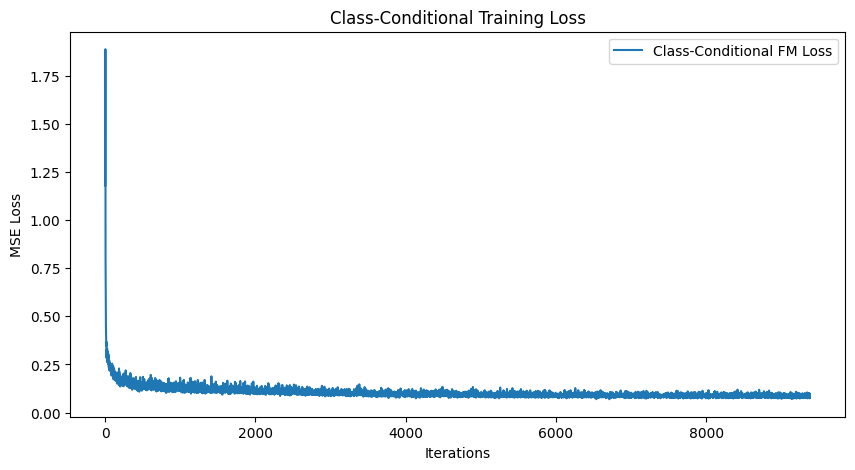

In [ ]:
num_epochs = 10
batch_size = 64
lr = 1e-2
gamma = 0.8
hidden_dim = 64
p_uncond = 0.1

model = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=hidden_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

class_fm_losses = []

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0

  for i, (images, labels) in enumerate(tqdm(train_loader)):
      images = images.to(device)
      labels = labels.to(device)

      loss = class_fm_forward(unet=model,x_1=images,c=labels,p_uncond=p_uncond,)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      class_fm_losses.append(loss.item())

  scheduler.step()
  print(f"Epoch {epoch+1} | Loss: {epoch_loss/len(train_loader):.4f}")

  if (epoch + 1) in [1, 5, 10]:
      ckpt_path = os.path.join(checkpoint_dir, f'class_unet_epoch_{epoch+1}.pth')
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': loss,
      }, ckpt_path)

plt.figure(figsize=(10, 5))
plt.plot(class_fm_losses, label='Class-Conditional FM Loss')
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.title('Class-Conditional Training Loss')
plt.legend()
plt.show()

# Part 2.6: Sampling from the Class-conditioned UNet

In [32]:
# Sampling from the UNet
def sample_class_grid(epoch_num):
    temp_model = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to(device)

    ckpt_path = os.path.join(checkpoint_dir, f'class_unet_epoch_{epoch_num}.pth')

    checkpoint = torch.load(ckpt_path, map_location=device)
    temp_model.load_state_dict(checkpoint['model_state_dict'])

    c = torch.arange(10, device=device).repeat(4)

    samples = class_fm_sample(unet=temp_model, c=c, img_wh=(28, 28), num_ts=50, guidance_scale=5.0)

    fig, axes = plt.subplots(4, 10, figsize=(15, 6))
    fig.suptitle(f"Epoch {epoch_num} Results (CFG $\gamma=5.0$)", y=0.98)

    for i in range(40):
        row = i // 10
        col = i % 10

        axes[row, col].imshow(samples[i].squeeze().cpu(), cmap='gray')
        axes[row, col].axis('off')

        if row == 0:
            axes[row, col].set_title(str(col))

    plt.tight_layout()
    plt.show()

sample_class_grid(1)
sample_class_grid(5)
sample_class_grid(10)

<>:15: SyntaxWarning: invalid escape sequence '\g'
<>:15: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-1922842979.py:15: SyntaxWarning: invalid escape sequence '\g'
  fig.suptitle(f"Epoch {epoch_num} Results (CFG $\gamma=5.0$)", y=0.98)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/cs180/proj5checkpoints/class_unet_epoch_1.pth'